In [1]:
import numpy as np
import random as rng
import numpy.random as numRand
import optproblems
from optproblems import cec2005
from optproblems import *
import typing 
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

In [3]:
# mutation functions

# not actually used so I don't haev to comment it ;D
def bitFlip(genotype, flip_probability):
    p = flip_probability
    
    for i in range(len(genotype)):
        if p >= np.random.rand(1, 1):
            genotype[i] = not(genotype[i])
    return genotype
#end

# gaussian convolution
# Add gaussian-distributed random numbers to a random selection of values from the genotype
# variance: variance of the distribution random numbers will be generated from
# min: minimum number genotype's values can be 
# max: maximum number genotype's values can be
# noise_probability: probability that gaussian number will be added a value in the genotype
def gaussianConvolution(genotype, variance, min = -100, max = 100, noise_probability=1):
    p = noise_probability #probability of adding noise to a genotype value
    var = variance        #variance of the gaussian distribution which will be added to a genotype val
    mu = 0                #mean of the normal distribution
    
    for i in range(len(genotype)): #for every genotype member
        # if the noise probability is greater than a random number (between 0 and 1)
        if p >= np.random.rand(1, 1): #a 1x1 array of random numbers (a.k.a a random number)
            #generate a random nnumber from a gaussian distribution
            randy_num = rng.normalvariate(mu, var)
            
            #until (current genotype value + randy_num) is between min and max
            while not (min <= genotype[i] + randy_num <= max):
                randy_num = rng.normalvariate(mu, var)
            #end
            
            genotype[i] = (genotype[i] + randy_num) #update current value from genotype
        #end
    return genotype
#end

mutate_functions = {"bit flip":bitFlip, "g convolve":gaussianConvolution}

In [30]:
# test mutation

pop = np.array([2, 2, 2, 2, 1, 1, 1, 1], dtype="float")
mut_pop = mutate_functions["g convolve"](pop, 5, 0.5)
mut_pop

array([11.03938395,  7.65042741,  7.12771142,  3.14647446,  2.76517444,
        3.62433529,  7.88704758,  4.04404438])

In [31]:
# recombination

# swap values between 2 vectors starting from a random index and ending at another random index
# (index circularly)
# vec_1: a vector
# vec_2: a vector
def twoPtCrossover(vec_1, vec_2):
    #TODO - implement
    vec_3, vec_4 = vec_1, vec_2
    return vec_3, vec_4
#end

#swap values between 2 vectors starting from a random index
#vec_1: a vector
#vec_2: a vector
def onePtCrossover(vec_1, vec_2):
    #TODO handle unequal-length vecs
    #TODO handle empty vecs
    
    # choose a random integer (between bidx and pop length) and
    # swap vector values between that index and the vectors' ends
    cross_beg_idx = int(rng.uniform(0, len(vec_1)))
    
    # if crossover start is greater than first index 
    # (crossing from zero would just output the same 2 vectors in reverse order)
    if cross_beg_idx > 0:
        # swap the values
        for idx in range(cross_beg_idx, len(vec_1)):
            swap = vec_1[idx] #store the value to be swapped
            vec_1[idx] = vec_2[idx]
            vec_2[idx] = swap #swap the value to be swapped
        #end
    #end
    return vec_1, vec_2
#end

recombine_fns = {"1-pt-crossover":onePtCrossover}

In [53]:
# test recombination
pop_1 = [4.0, 3.2, 1.0, 0.5, 6.2]
pop_2 = [10.0, 15.0, 12.2, 9.5, 5.0]

pop_3, pop_4 = onePtCrossover(pop_1, pop_2)

print(pop_3)
pop_4

[10.0, 15.0, 12.2, 9.5, 5.0]


[4.0, 3.2, 1.0, 0.5, 6.2]

In [91]:
#selection

# Assess a genotype's fitness score in relation to a given problem function
# In GA, allows GA to find genotypes with greatest fitness and "naturally select" them
def assessFitness(genotype, problem):
    if genotype == None:
        fitness = np.inf
    else:
        solution = Individual(genotype)
        problem.evaluate(solution)
        fitness = solution.objective_values
    #end
    
    return fitness
#end

# select the best genotype from the population according to a tournament process
def tournamentSelect(population, tournament_size, problem):
    t = tournament_size
    
    select_idx = int(rng.uniform(0, len(population)))
    best_idx = select_idx
    best = population[select_idx]
    
    # for every population element between second and "tournament size"...
    for i in range(1, len(population)):
        # choose a "next" at random from pop
        select_idx = rng.uniform(0, len(population))
        next = population[select_idx]
        
        # if fitness of Next better than best...
        if assessFitness(next, problem) > assessFitness(best, problem):
            # best = next
            best = next
        #end
    #end
    
    return best
#end

# select the best genotype from the population according to a tournament process
def tournamentSelectAtIdx(population, tournament_size, problem):
    t = tournament_size
    
    select_idx = int(rng.uniform(0, len(population)))
    best_idx = next_idx
    best = population[select_idx]
    
    # for every population element between second and "tournament size"...
    for i in range(1, len(population)):
        # choose a "next" at random from pop
        select_idx = int(rng.uniform(0, len(population)))
        next = population[select_idx]
        
        # if fitness of next better than best...
        if assessFitness(next, problem) > assessFitness(best, problem):
            best = next #next is the new best. Remember the new best
            best_idx = i #remember the best's index
        #end
    #end
    
    return best, best_idx
#end

In [92]:
# genetic algorithm
PROBLEM_SIZE = 10

def geneticAlgorithm(generation_limit = 10, population_size = 10, problem_size = PROBLEM_SIZE, problem = optproblems.Problem(cec2005.F1(PROBLEM_SIZE))):
    # TODO optimise for fitness checks
    # create population
    pop = list()
    for i in range(problem_size):
        pop.append(list(numRand.rand(1, problem_size)[0]))
#         print("Fitness {}: {}".format(i, assessFitness(pop[i], problem)))
    #end
    
    best = None
    fitness = np.inf
    generation = 0
    
    # assess fitnesses and assign best until best is the ideal solution
    while not ((fitness <= 0) or (generation_limit <= generation)):   
#         print("Gen: {}\n".format(generation))
        for idx in range(len(pop)):
#             print("Individual: {}\tFitness: {}\n".format(idx, assessFitness(best, problem)))
            if assessFitness(pop[idx], problem) < assessFitness(best, problem):
                best = pop[idx]
#                 best_fit = assessFitness(best, problem)
#                 print()
#                 print("New best {}".format(best_fit))
#                 print()
            #end
        #end
        
        # create next generation
        next_generation = list()
        for i in range(problem_size):
            next_generation.append(list(numRand.rand(1, problem_size)[0]))
        #end
        generation += 1
        
        # mutate and recombine
        for i in range(0, len(pop)):
            clone_pop = pop.copy()
            tourney_size = len(clone_pop)/2
            mum, idx_1 = tournamentSelectAtIdx(clone_pop, tourney_size, problem)
            
            clone_pop = np.array(clone_pop)
            clone_pop = pn.delete(clone_pop, idx_1)
            clone_pop = list(clone_pop)
            
            dad, _ = tournamentSelectAtIdx(clone_pop, tourney_size, problem)
            
            child_a, child_b = onePtCrossover(mum.copy(), dad.copy())
            
            next_generation.append(child_a)
            next_generation.append(child_b)
        
    #end
    
    fitness = assessFitness(best, problem)

#     print(" {}\n {}".format(best, fitness))
    
    return fitness
#end

geneticAlgorithm()
print("done")

NameError: name 'next_idx' is not defined

In [ ]:
genotype1 = [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]
genotype2 = [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]

PROBLEM_LENGTH = 10
problem = optproblems.Problem(cec2005.F1(PROBLEM_LENGTH))
solution = Individual(genotype2)
problem.evaluate(solution)
fitness = solution.objective_values

fitness

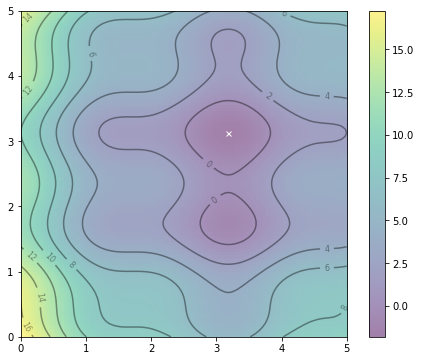

In [72]:
# Not actually our code
# This is an example from [link] ad completely irrelevant to our solution
import numpy as np
import matplotlib.pyplot as plt
 
def f(x,y):
    "Objective function"
    return (x-3.14)**2 + (y-2.72)**2 + np.sin(3*x+1.41) + np.sin(4*y-1.73)
 
# Contour plot: With the global minimum showed as "X" on the plot
x, y = np.array(np.meshgrid(np.linspace(0,5,100), np.linspace(0,5,100)))
z = f(x, y)
x_min = x.ravel()[z.argmin()]
y_min = y.ravel()[z.argmin()]
plt.figure(figsize=(8,6))
plt.imshow(z, extent=[0, 5, 0, 5], origin='lower', cmap='viridis', alpha=0.5)
plt.colorbar()
plt.plot([x_min], [y_min], marker='x', markersize=5, color="white")
contours = plt.contour(x, y, z, 10, colors='black', alpha=0.4)
plt.clabel(contours, inline=True, fontsize=8, fmt="%.0f")
plt.show()

n_particles = 20
X = np.random.rand(2, n_particles) * 5
V = np.random.randn(2, n_particles) * 0.1

pbest = X
pbest_obj = f(X[0], X[1])
gbest = pbest[:, pbest_obj.argmin()]
gbest_obj = pbest_obj.min()

c1 = c2 = 0.1
w = 0.8
# One iteration
r = np.random.rand(2)
V = w * V + c1*r[0]*(pbest - X) + c2*r[1]*(gbest.reshape(-1,1)-X)
X = X + V
obj = f(X[0], X[1])
pbest[:, (pbest_obj >= obj)] = X[:, (pbest_obj >= obj)]
pbest_obj = np.array([pbest_obj, obj]).max(axis=0)
gbest = pbest[:, pbest_obj.argmin()]
gbest_obj = pbest_obj.min()

In [76]:
def snipAThing(thing):
#     thing = np.array(thing)
    thing = np.delete(thing, 4)
#end

thang = np.array([7, 6, 5, 4, 3, 2, 1, 0]) 

snipAThing(thang)

thang

array([7, 6, 5, 4, 3, 2, 1, 0])